In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Functions for Preprocessing & Scaling Data

In [3]:
# Import the necessary libraries
import pandas as pd
import numpy as np

# Run the code again to define and test the Min-Max scaling functions
# Define the function for Min-Max scaling
def min_max_scaling(data):
    """
    Normalize the data using Min-Max scaling.
    Args:
    - data (DataFrame): The data to normalize

    Returns:
    - normalized_data (DataFrame): The normalized data
    - scaling_params (dict): The minimum and maximum values used for scaling for each column
    """
    scaling_params = {}
    normalized_data = data.copy()

    for column in data.columns:
        min_val = data[column].min()
        max_val = data[column].max()
        scaling_params[column] = {'min': min_val, 'max': max_val}
        normalized_data[column] = (data[column] - min_val) / (max_val - min_val)

    return normalized_data, scaling_params

# Define the function for inverse Min-Max scaling
def inverse_min_max_scaling(normalized_data, scaling_params):
    """
    Reverse the Min-Max scaling to get the original data.
    Args:
    - normalized_data (DataFrame): The normalized data
    - scaling_params (dict): The minimum and maximum values used for scaling for each column

    Returns:
    - original_data (DataFrame): The data in its original scale
    """
    original_data = normalized_data.copy()

    for idx, column in enumerate(normalized_data.columns):
        # Convert integer column names to string to match with scaling_params keys
        key = str(column) if isinstance(column, int) else column
        keys = list(scaling_params.keys())
        min_val = scaling_params[keys[int(key)]]['min']
        max_val = scaling_params[keys[int(key)]]['max']
        original_data[int(column)] = normalized_data[int(column)] * (max_val - min_val) + min_val
        original_data = original_data.applymap(lambda x: max(0, x))

    return original_data

# Outlier Handling Functions

**Replace outliers for each weekday and each time slot with median for that slot and weekday**

In [ ]:
# def outlier_handler(data):
#     # Convert the 'date' column to datetime format
#     data['date'] = pd.to_datetime(data['date'])

#     # Extract day of the week and time from the 'date' column
#     data['day_of_week'] = data['date'].dt.day_name()
#     data['time'] = data['date'].dt.time

#     # Define a function to replace outliers with median for each group
#     def replace_outliers(group):
#         # Iterate over each column in the group
#         for col in group.columns:
#             if col not in ['date', 'day_of_week', 'time']:
#                 # Compute the IQR
#                 Q1 = group[col].quantile(0.25)
#                 Q3 = group[col].quantile(0.75)
#                 IQR = Q3 - Q1

#                 # Define bounds for outliers
#                 lower_bound = Q1 - 1.5 * IQR
#                 upper_bound = Q3 + 1.5 * IQR

#                 # Replace outliers with median of the group
#                 median_val = group[col].median()
#                 group[col] = group[col].apply(lambda x: median_val if x < lower_bound or x > upper_bound else x)

#         return group

#     # Group by 'day_of_week' and 'time' and apply the function to replace outliers
#     data = data.groupby(['day_of_week', 'time']).apply(replace_outliers)
#     data = data.drop(columns=['day_of_week','time'])

#     return data

# Function for Handling Zero Points

In [4]:
def zero_handler(data, range):
    data['date'] = pd.to_datetime(data['date'])
    data['weekday'] = data['date'].dt.dayofweek
    data['time'] = data['date'].dt.time

    # Loop over each segment column
    for col in data.columns[1:-2]:
        # Group by weekday and time slot
        grouped = data.groupby(['weekday', 'time'])

        # Define a function to apply to each group
        def replace_zeros(group):
            nonzero_mean = group[group != 0].mean()
            if pd.notnull(nonzero_mean):
                return group.replace(0, nonzero_mean)
            else:
                return group

        # Apply the function to each group in the specific segment column
        data[col] = grouped[col].transform(replace_zeros)

    data = data.drop(columns=['weekday','time'])

    return data

In [5]:
def handle_zeros_with_rolling_mean(data, range_num):
    for col in data.columns[1:]:
        mv_avg = data[col].rolling(range_num).mean()

        for i in range(range_num,len(data[col])):
            data.loc[i-range_num:i+1,col].mean()

        for i, val in enumerate(data[col]):
            if val == 0:
                data.loc[i,col] = mv_avg[i]
    data = data.tail(-(range_num))
    return data

In [6]:
import math

# range_num = 18
# col = '5'

def fill_zeros_median(data, range_num):
    for col in data.columns[1:]:
        for i in range(range_num-1, len(data)):
            if data.loc[i,col] == 0:
                avg = data.loc[i-range_num:i+1,col].loc[data.loc[i-range_num:i+1,col] != 0 ].median()
                if math.isnan(avg):
                    avg = data.loc[i-range:i+range_num,col].loc[data.loc[i-range:i+range_num,col] != 0 ].median()
                    if math.isnan(avg):
                        # avg = data.loc[:,col].loc[data.loc[:,col] != 0 ].median()
                        avg = 0
                        # if math.isnan(avg):
                        #     avg = data1.loc[i:i+100,'3'].loc[data1.loc[i:i+100,'3'] != 0 ].mean()
                data.loc[i,col] = avg

    return data.tail(-(range_num))



# Function for Moving Average Filter

In [7]:
def moving_avg_filter(data, window):
    # Calculate the 3-period moving average for each column (excluding the 'date' column)
    for col in data.columns:
        if col != 'date':
            data[col] = data[col].rolling(window).mean()


    # Since the first two rows will have NaN values due to the 3-period moving average,
    # fill them using forward fill.
    data.fillna(method='ffill', inplace=True)

    # Replace any remaining NaN values with zero
    data.fillna(0, inplace=True)

    data = data.tail(-(window-1))

    return data

# Function for Converting data into sequential data

**Get a matrix of 8 hour window as X and its next step values as Y**

In [ ]:
# def formatting_features_targets(data_values, window_size, pred_steps):
#     # Preprocessing and reshaping data
#     num_sequences = len(data_values) - window_size - pred_steps
#     print(num_sequences)
#     X = np.array([data_values[i:i+window_size] for i in range(num_sequences)])
#     y = np.array([data_values[i+window_size] for i in range(num_sequences + pred_steps)])
#     print(X.shape)
#     X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])

#     y_new = np.empty((X.shape[0], X.shape[2]*pred_steps))
#     print(y_new.shape)
#     for i in range(len(y)- pred_steps):
#         y_point = np.array(y[i])
#         j = i + 1
#         for i in range(pred_steps -1):
#             np.append(y_point, y[j])
#             j+= 1
#         y_new[i] = y_point



#     return X, y_new

In [8]:
def formatting_features_targets(data_values, window_size, pred_steps):
    # Preprocessing and reshaping data
    num_sequences = len(data_values) - window_size - pred_steps
    X = np.array([data_values[i:i+window_size] for i in range(num_sequences)])
    y = np.array([data_values[i+window_size] for i in range(num_sequences + pred_steps)])
    X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])
    # y = y.reshape(y.shape[0], 75)

    yy = np.empty((len(X), pred_steps*(y.shape[1])))
    for i in range(len(X)):
        a = y[i]
        for j in range(1, pred_steps):
            a = np.append(a, y[i+j])
        yy[i] = a

    return X, yy

In [9]:
# def flat(lis):
#     flatList = []
#     # Iterate with outer list
#     for element in lis:
#         if type(element) is list:
#             # Check if type is list than iterate through the sublist
#             for item in element:
#                 flatList.append(item)
#         else:
#             flatList.append(element)
#     return flatList

In [10]:
# def formatting_features_targets(data_values, window_size, pred_steps):
#     # Preprocessing and reshaping data
#     num_sequences = len(data_values) - window_size - pred_steps
#     X = np.array([data_values[i:i+window_size] for i in range(num_sequences)])
#     y = np.array([data_values[i+window_size:i+window_size+pred_steps] for i in range(num_sequences)])


#     for i in range(num_sequences):
#         list1 = []
#         y_elem = list1.extend(data_values[i+window_size:i+window_size+pred_steps])


#     y = np.empty()
#     for i in range(num_sequences):
#         y_elem = np.array(data_values[i+window_size:i+window_size+pred_steps])
#         y = np.append(y, y_elem)

#     return X, y

# Transformer Model

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SpatioTemporalModel(nn.Module):
    def __init__(self, input_size, output_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dropout_rate=0.1):
        super(SpatioTemporalModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        # self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        # self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the flattened size after convolutional layers
        self.flattened_size = (input_size[1] // 4) * (input_size[2] // 4) * 32  # Dividing by 4 due to two pooling layers
        # Bottleneck layer to adjust the dimensionality to d_model
        self.bottleneck = nn.Linear(self.flattened_size, d_model)

        # Transformer layers
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_rate
        )

        # Linear layer for prediction
        self.fc1 = nn.Linear(d_model, d_model//2)
        self.fc2 = nn.Linear(d_model//2, d_model//4)
        self.fc3 = nn.Linear(d_model//4, output_size)

    def forward(self, x):
        # Convolutional layers
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        # Flattening
        x = x.view(x.size(0), -1)
        x = self.bottleneck(x)

        # Transformer layers
        x = x.unsqueeze(0)
        x = self.transformer(x, x)
        x = x.squeeze(0)

        # Linear layer for prediction
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

# Placing Data into Torch Tensors Functions

In [12]:
def get_torch_tensor(df, device):
    return torch.tensor(df, dtype=torch.float32).to(device)

def get_data_loader(X, y, device, batch_size, shuffle):
    X_tensor = get_torch_tensor(X, device)
    y_tensor = get_torch_tensor(y, device)
    tensor_dataset = TensorDataset(X_tensor, y_tensor)
    data_loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=shuffle)
    return data_loader

def get_train_val_test_loaders(X_scaled, y_scaled, val_fraction, test_fraction, device, batch_size):
    test_splitter = round(len(X_scaled)*(1-test_fraction))
    X_train_val_scaled , X_test_scaled = X_scaled[:test_splitter] , X_scaled[test_splitter:]
    y_train_val_scaled , y_test_scaled = y_scaled[:test_splitter] , y_scaled[test_splitter:]

    train_val_splitter = round(len(X_train_val_scaled)*(1-val_fraction))
    X_train_scaled , X_val_scaled = X_train_val_scaled[:train_val_splitter] , X_train_val_scaled[train_val_splitter:]
    y_train_scaled , y_val_scaled = y_train_val_scaled[:train_val_splitter] , y_train_val_scaled[train_val_splitter:]

    train_loader = get_data_loader(X_train_scaled, y_train_scaled, device, batch_size, True)
    val_loader = get_data_loader(X_val_scaled, y_val_scaled, device, batch_size, False)
    test_loader = get_data_loader(X_test_scaled, y_test_scaled, device, batch_size, False)

    return train_loader, val_loader, test_loader

# Training

In [36]:
def training(model, train_loader, val_loader, patience=3):
    # Training loop with tqdm progress bar
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    num_epochs = 25
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
            with torch.no_grad():
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                total_val_loss+=loss
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] => Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Implement early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= patience:
            print(f"Early stopping after {epoch + 1} epochs without improvement.")
            break

# Error Metrics Functions

## For Overall

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def evaluateModel(model, val_loader, device, scaling_params=None, pred_steps=1):
    """
    Evaluate the model and return MSE, RMSE, and MAE.

    Args:
    - model: The trained model
    - val_loader: DataLoader for the validation set
    - device: The device type ('cpu' or 'cuda')
    - scaling_params (dict, optional): The minimum and maximum values used for scaling for each column

    Returns:
    - mse (float): Mean Squared Error
    - rmse (float): Root Mean Squared Error
    - mae (float): Mean Absolute Error
    """
    model.eval()  # Set model to evaluation mode

    all_predictions = []
    all_true_values = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            predictions = model(X_batch)
            all_predictions.extend(predictions.cpu().numpy())
            all_true_values.extend(y_batch.cpu().numpy())

    num_seg = int(len(all_predictions[0]) / pred_steps)
    # print(num_seg)
    for i in range(0, pred_steps):
        print(f"Time Step {i+1}")
        start_idx = i*num_seg
        # print(start_idx)
        step_predictions = [all_predictions[j][start_idx:start_idx+num_seg] for j in range(len(all_predictions))]
        step_true_values = [all_true_values[j][start_idx:start_idx+num_seg] for j in range(len(all_true_values))]

        # If scaling_params are provided, reverse the normalization
        if scaling_params:
            step_predictions = inverse_min_max_scaling(pd.DataFrame(step_predictions), scaling_params).values
            step_true_values = inverse_min_max_scaling(pd.DataFrame(step_true_values), scaling_params).values

            mse = mean_squared_error(step_true_values, step_predictions)
            rmse = mean_squared_error(step_true_values, step_predictions, squared=False)
            mae = mean_absolute_error(step_true_values, step_predictions)
            mape = mean_absolute_percentage_error(step_true_values, step_predictions)

            print(f"Time Step {i+1} ==> MSE: {mse:.4f} --- RMSE: {rmse:.4f} --- MAE: {mae:.4f} --- MAPE: {mape:.4f}")
    # return mse, rmse, mae

# Dummy code to simulate usage (We don't have the actual model and data here, so this is just for illustration)
# evaluate_model(model, val_loader, device, scaling_params)


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def generateOutput(model, val_loader, device, scaling_params=None):

    model.eval()  # Set model to evaluation mode

    all_predictions = []
    all_true_values = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            predictions = model(X_batch)
            all_predictions.extend(predictions.cpu().numpy())
            all_true_values.extend(y_batch.cpu().numpy())

    # If scaling_params are provided, reverse the normalization
    if scaling_params:
        all_predictions = inverse_min_max_scaling(pd.DataFrame(all_predictions), scaling_params).values
        all_true_values = inverse_min_max_scaling(pd.DataFrame(all_true_values), scaling_params).values

    return all_predictions

# Dummy code to simulate usage (We don't have the actual model and data here, so this is just for illustration)
# evaluate_model(model, val_loader, device, scaling_params)


## Errors by Segment

In [ ]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# # Let's update the evaluate_model_per_segment function to compute MSE, RMSE, and MAE for each segment
# def evaluate_model_per_segment(model, val_loader, device, scaling_params=None):
#     """
#     Evaluate the model for each segment and return metrics.

#     Args:
#     - model: The trained model
#     - val_loader: DataLoader for the validation set
#     - device: The device type ('cpu' or 'cuda')
#     - scaling_params (dict, optional): The minimum and maximum values used for scaling for each column

#     Returns:
#     - segment_metrics (dict): Metrics (MSE, RMSE, MAE) for each segment
#     """
#     model.eval()  # Set model to evaluation mode

#     all_predictions = []
#     all_true_values = []

#     # Fetch predictions and true values
#     with torch.no_grad():
#         for X_batch, y_batch in val_loader:
#             X_batch = X_batch.to(device)
#             predictions = model(X_batch)
#             all_predictions.extend(predictions.cpu().numpy())
#             all_true_values.extend(y_batch.cpu().numpy())

#     # Convert to arrays for indexing
#     all_predictions = np.array(all_predictions)
#     all_true_values = np.array(all_true_values)

#     # If scaling_params are provided, reverse the normalization
#     if scaling_params:
#         all_predictions = inverse_min_max_scaling(pd.DataFrame(all_predictions), scaling_params).values
#         all_true_values = inverse_min_max_scaling(pd.DataFrame(all_true_values), scaling_params).values

#     num_segments = all_predictions.shape[1]
#     segment_metrics = {}

#     from sklearn.metrics import mean_absolute_error
#     overall_mae = mean_absolute_error(all_predictions, all_true_values)
#     print(f"Overall Error Metrics ==> MAE : {overall_mae}")

#     # Calculate MSE, RMSE, and MAE for each segment
#     for segment_idx in range(num_segments):
#         segment_predictions = all_predictions[:, segment_idx]
#         segment_true_values = all_true_values[:, segment_idx]

#         mse = np.mean((segment_predictions - segment_true_values)**2)
#         rmse = np.sqrt(mse)
#         # mae = np.mean(np.abs(segment_predictions - segment_true_values))
#         mae = mean_absolute_error(segment_predictions, segment_true_values)

#         segment_metrics[f"Segment {segment_idx+1}"] = {"MSE": mse, "RMSE": rmse, "MAE": mae}

#     return segment_metrics

# def evaluate_segments(model, test_loader, device, scaling_params=None):
#     segment_metrics = evaluate_model_per_segment(model, test_loader, device, scaling_params)

#     # Display metrics for each segment
#     for segment, metrics in segment_metrics.items():
#         print(f"{segment} => MSE: {metrics['MSE']:.4f}, RMSE: {metrics['RMSE']:.4f}, MAE: {metrics['MAE']:.4f}")


## Visualizing Performance of Model against each segment

In [17]:
# Import Matplotlib for plotting
import matplotlib.pyplot as plt

# Update the visualize_sorted_predictions function to reverse the normalization
def visualize_sorted_predictions(model, val_loader, device, scaling_params=None, pred_steps=1, num_seg=15):
    """
    Visualize the sorted predictions and true values in their original scale.

    Args:
    - model: The trained model
    - val_loader: DataLoader for the validation set
    - device: The device type ('cpu' or 'cuda')
    - scaling_params (dict, optional): The minimum and maximum values used for scaling for each column
    """

    mae_df = pd.DataFrame(index=range(num_seg), columns=range(pred_steps))
    mse_df = pd.DataFrame(index=range(num_seg), columns=range(pred_steps))
    rmse_df = pd.DataFrame(index=range(num_seg), columns=range(pred_steps))
    mape_df = pd.DataFrame(index=range(num_seg), columns=range(pred_steps))

    model.eval()  # Set model to evaluation mode

    all_predictions = []
    all_true_values = []

    # Fetch predictions and true values
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            predictions = model(X_batch)
            all_predictions.extend(predictions.cpu().numpy())
            all_true_values.extend(y_batch.cpu().numpy())

    # Convert to arrays for indexing
    all_predictions = np.array(all_predictions)
    all_true_values = np.array(all_true_values)

    num_seg = int(all_predictions.shape[1] / pred_steps)
    # print(inverse_min_max_scaling(pd.DataFrame(all_predictions), scaling_params))

    fig, axs = plt.subplots(num_seg, pred_steps, figsize=(50,50) )

    for i in range(0, pred_steps):
        # print(f"Time Step {i+1}")
        start_idx = i*num_seg
        # print(start_idx)
        step_predictions = [all_predictions[j][start_idx:start_idx+num_seg] for j in range(len(all_predictions))]
        step_true_values = [all_true_values[j][start_idx:start_idx+num_seg] for j in range(len(all_true_values))]

        # If scaling_params are provided, reverse the normalization
        if scaling_params:
            step_predictions = inverse_min_max_scaling(pd.DataFrame(step_predictions), scaling_params).values
            step_true_values = inverse_min_max_scaling(pd.DataFrame(step_true_values), scaling_params).values

        # Plotting each segment
        for segment_idx in range(num_seg):
            segment_predictions = step_predictions[:, segment_idx]
            segment_true_values = step_true_values[:, segment_idx]

            # Sorting the actual values and adjusting predictions accordingly
            # sorted_indices = np.argsort(segment_true_values)
            # sorted_true_values = segment_true_values[sorted_indices]
            # sorted_predictions = segment_predictions[sorted_indices]

            # sorted_indices = np.argsort(segment_true_values)
            sorted_true_values = segment_true_values
            sorted_predictions = segment_predictions

            mse = mean_squared_error(sorted_true_values, sorted_predictions)
            rmse = mean_squared_error(sorted_true_values, sorted_predictions, squared=False)
            mae = mean_absolute_error(sorted_true_values, sorted_predictions)
            mape = mean_absolute_percentage_error(sorted_true_values, sorted_predictions)*100

            mae_df.loc[segment_idx, i] = mae
            mse_df.loc[segment_idx, i] = mse
            rmse_df.loc[segment_idx, i] = rmse
            mape_df.loc[segment_idx, i] = mape

            axs[segment_idx, i].plot(sorted_true_values, label="Actual", color='blue')
            axs[segment_idx, i].plot(sorted_predictions, label="Predicted", color='red')
            axs[segment_idx, i].set_title(f'Segment {segment_idx} : Time Step {i} - MAE:{mae:.2f}')

            # plt.figure(figsize=(5, 4))
            # plt.plot(sorted_true_values, label="Actual Values", color='blue')
            # plt.plot(sorted_predictions, label="Predicted Values", color='red')
            # plt.title(f"Segment {segment_idx+1}")
            # plt.xlabel("Sequence Index")
            # plt.ylabel("Value")
            # plt.legend()
            # plt.show()
    for i, ax in enumerate(axs.flat):
        ax.set(xlabel=f'Time Step {(i+1)%pred_steps}')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

    return mae_df, mse_df, rmse_df, mape_df


# Obtainig GPU CUDA

In [18]:
# Check if CUDA is available and move the model to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Loading the Data

In [19]:
# timestep used for data
minutes = 5

pred_steps = 12

In [21]:
# Load the dataset
# data = pd.read_csv('/content/drive/MyDrive/data/Initial.csv')

# orig_df = pd.read_csv(f'/content/drive/MyDrive/datasets/avg_run_{minutes}min_dir1v2.csv')

# orig_df = pd.read_csv(f'/content/drive/MyDrive/Semester 5 DSE Project/Data/avg_run_{minutes}min_dir1v2.csv')

orig_df = pd.read_csv(f'/content/drive/MyDrive/Project Datasets/avg_run_{minutes}min_dir1v2.csv')

orig_df = orig_df.drop(columns=['temp','precip','windspeed'])

# Applying the ML Process

In [23]:
data1 = orig_df

zero_handle_range = int((15/minutes)*6)
# zero_handle_range = 60
# zero_handle_range = (zero_handle_range - 6)
data1 = zero_handler(data1, zero_handle_range)
data1_save = fill_zeros_median(data1, zero_handle_range)
data2 = data1_save.drop(columns=['date'])

data2, scaling_params2 = min_max_scaling(data2)
data_values2 = data2.values

window_size = int(8/(minutes/60))
# step_i = 1
pred_steps = 12
X2, y2 = formatting_features_targets(data_values2, window_size, pred_steps)

In [31]:
# Initialize the model
# Hyperparameters for the transformer and the model
d_model = 512
batchSize = 64
nhead = 8
num_encoder_layers = 2
num_decoder_layers = 2
# Initialize the model
model2 = SpatioTemporalModel(input_size=X2.shape[1:], output_size=y2.shape[1], d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [34]:
validation_percentage = 0.2
test_percentage = 0.2
train_loader2, val_loader2, test_loader2 = get_train_val_test_loaders(X2, y2, test_percentage, validation_percentage, device, batchSize)

In [37]:
model2.to(device)
training(model2, train_loader2, val_loader2)

Epoch 1 Validation: 100%|██████████| 94/94 [00:00<00:00, 191.18it/s]


Epoch [1/25] => Train Loss: 0.0033, Val Loss: 0.0022


Epoch 2 Validation: 100%|██████████| 94/94 [00:00<00:00, 200.96it/s]


Epoch [2/25] => Train Loss: 0.0027, Val Loss: 0.0020


Epoch 3 Validation: 100%|██████████| 94/94 [00:00<00:00, 203.69it/s]


Epoch [3/25] => Train Loss: 0.0024, Val Loss: 0.0020


Epoch 4 Validation: 100%|██████████| 94/94 [00:00<00:00, 139.59it/s]


Epoch [4/25] => Train Loss: 0.0023, Val Loss: 0.0019


Epoch 5 Validation: 100%|██████████| 94/94 [00:00<00:00, 202.80it/s]


Epoch [5/25] => Train Loss: 0.0022, Val Loss: 0.0019


Epoch 6 Validation: 100%|██████████| 94/94 [00:00<00:00, 207.13it/s]


Epoch [6/25] => Train Loss: 0.0021, Val Loss: 0.0019


Epoch 7 Validation: 100%|██████████| 94/94 [00:00<00:00, 202.49it/s]


Epoch [7/25] => Train Loss: 0.0020, Val Loss: 0.0019


Epoch 8 Validation: 100%|██████████| 94/94 [00:00<00:00, 203.22it/s]


Epoch [8/25] => Train Loss: 0.0019, Val Loss: 0.0019


Epoch 9 Validation: 100%|██████████| 94/94 [00:00<00:00, 137.39it/s]


Epoch [9/25] => Train Loss: 0.0018, Val Loss: 0.0019


Epoch 10 Validation: 100%|██████████| 94/94 [00:00<00:00, 206.16it/s]


Epoch [10/25] => Train Loss: 0.0017, Val Loss: 0.0019


Epoch 11 Validation: 100%|██████████| 94/94 [00:00<00:00, 198.31it/s]


Epoch [11/25] => Train Loss: 0.0017, Val Loss: 0.0019


Epoch 12 Validation: 100%|██████████| 94/94 [00:00<00:00, 206.78it/s]


Epoch [12/25] => Train Loss: 0.0016, Val Loss: 0.0019


Epoch 13 Validation: 100%|██████████| 94/94 [00:00<00:00, 203.44it/s]


Epoch [13/25] => Train Loss: 0.0015, Val Loss: 0.0019


Epoch 14 Validation: 100%|██████████| 94/94 [00:00<00:00, 132.56it/s]


Epoch [14/25] => Train Loss: 0.0015, Val Loss: 0.0019


Epoch 15 Validation: 100%|██████████| 94/94 [00:00<00:00, 204.99it/s]


Epoch [15/25] => Train Loss: 0.0014, Val Loss: 0.0019


Epoch 16 Validation: 100%|██████████| 94/94 [00:00<00:00, 195.22it/s]


Epoch [16/25] => Train Loss: 0.0014, Val Loss: 0.0020


Epoch 17 Validation: 100%|██████████| 94/94 [00:00<00:00, 205.02it/s]

Epoch [17/25] => Train Loss: 0.0013, Val Loss: 0.0019
Early stopping after 17 epochs without improvement.


In [38]:
print("Training Error")
evaluateModel(model2, train_loader2, device, scaling_params2, pred_steps)
print()
print("Val Error")
evaluateModel(model2, val_loader2, device, scaling_params2, pred_steps)
print()
print("Test Error")
evaluateModel(model2, test_loader2, device, scaling_params2, pred_steps)
# print(f"MSE: {mse2:.4f}, RMSE: {rmse2:.4f}, MAE: {mae2:.4f}")
# v1 - MSE: 1747.1942, RMSE: 33.6750, MAE: 25.9307
# v3 - MSE: 1448.6693, RMSE: 31.2468, MAE: 23.5870
# v4 - MSE: 2346.4839, RMSE: 37.4656, MAE: 30.4317 batch size = 1

# 10 min - MSE: 404.0626, RMSE: 16.7137, MAE: 10.1751
# 5  min - MSE: 107.9190, RMSE: 8.8442, MAE: 2.0576
# 15 min - MSE: 478.6729, RMSE: 18.7366, MAE: 12.1529

# with zerohandler
#  5 min - MSE: 165.3000, RMSE: 11.0085, MAE: 5.8335

# with new dataset - 5min
# MSE: 6884.2031, RMSE: 36.9460, MAE: 35.5767

Training Error
Time Step 1
Time Step 1 ==> MSE: 833.6250 --- RMSE: 26.1849 --- MAE: 17.7893 --- MAPE: 0.1139
Time Step 2
Time Step 2 ==> MSE: 776.1254 --- RMSE: 25.2361 --- MAE: 17.3960 --- MAPE: 0.1103
Time Step 3
Time Step 3 ==> MSE: 732.2059 --- RMSE: 24.6797 --- MAE: 17.0265 --- MAPE: 0.1107
Time Step 4
Time Step 4 ==> MSE: 731.2560 --- RMSE: 24.5916 --- MAE: 16.8335 --- MAPE: 0.1084
Time Step 5
Time Step 5 ==> MSE: 737.9323 --- RMSE: 24.6993 --- MAE: 17.0456 --- MAPE: 0.1108
Time Step 6
Time Step 6 ==> MSE: 717.4929 --- RMSE: 24.3941 --- MAE: 16.7079 --- MAPE: 0.1084
Time Step 7
Time Step 7 ==> MSE: 739.2899 --- RMSE: 24.7315 --- MAE: 16.9121 --- MAPE: 0.1076
Time Step 8
Time Step 8 ==> MSE: 749.6984 --- RMSE: 24.8738 --- MAE: 16.9950 --- MAPE: 0.1081
Time Step 9
Time Step 9 ==> MSE: 760.9052 --- RMSE: 25.0805 --- MAE: 17.1056 --- MAPE: 0.1100
Time Step 10
Time Step 10 ==> MSE: 749.4979 --- RMSE: 25.0022 --- MAE: 17.1134 --- MAPE: 0.1078
Time Step 11
Time Step 11 ==> MSE: 747.0153

In [39]:
# evaluate_segments(model2, test_loader2, device, scaling_params2)

# # Segments 2, 9, 10

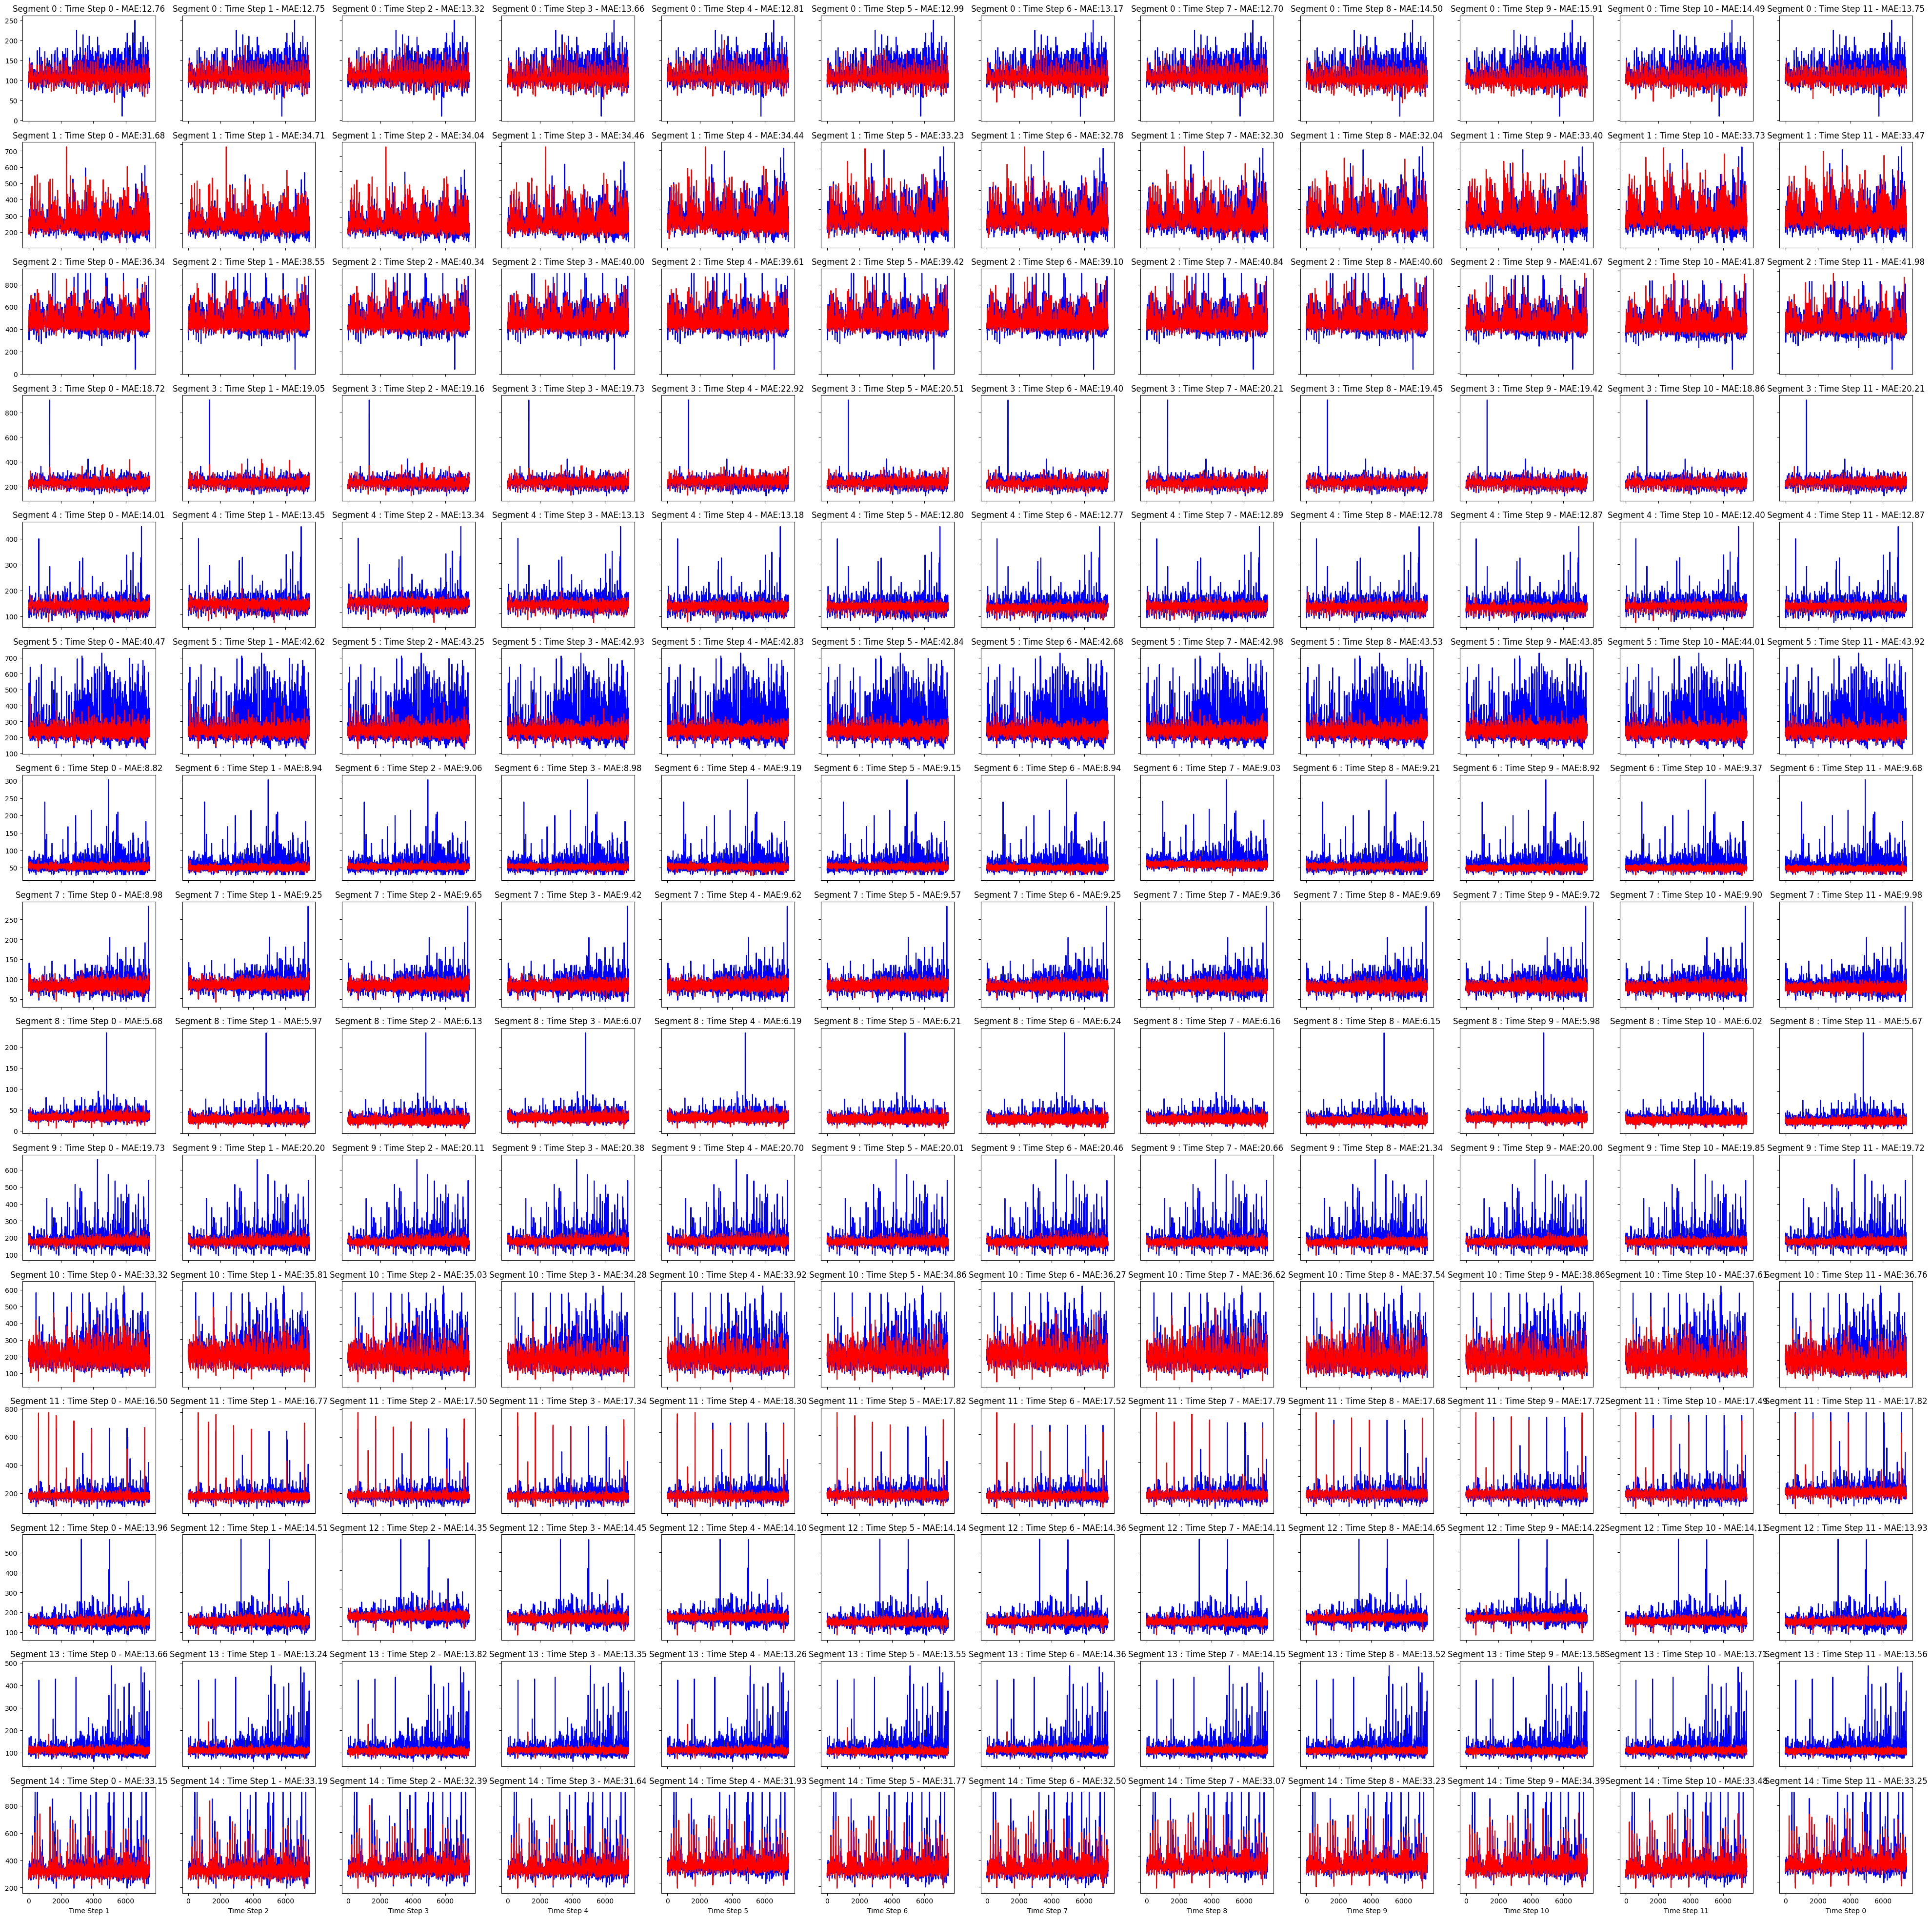

In [40]:
mae_df, mse_df, rmse_df, mape_df = visualize_sorted_predictions(model2, test_loader2, device, scaling_params2, pred_steps)

In [41]:
mae_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,12.763363,12.745623,13.317916,13.657622,12.812473,12.990304,13.171406,12.704921,14.498537,15.909467,14.492529,13.746329
1,31.679772,34.705241,34.04108,34.459612,34.444054,33.225382,32.779025,32.297433,32.043354,33.400419,33.728482,33.465196
2,36.337654,38.549879,40.340537,39.997825,39.612541,39.424398,39.096126,40.84179,40.598297,41.67455,41.865933,41.983473
3,18.722133,19.047624,19.164987,19.726492,22.92221,20.506464,19.399085,20.212787,19.453448,19.416991,18.857724,20.209538
4,14.009655,13.450869,13.343474,13.130514,13.181743,12.804793,12.76531,12.885942,12.783465,12.873497,12.40296,12.873961
5,40.469618,42.615428,43.252298,42.929824,42.828067,42.842666,42.680395,42.982222,43.53104,43.845217,44.014852,43.915599
6,8.822072,8.940997,9.057527,8.975053,9.19407,9.150629,8.944756,9.034531,9.208586,8.92465,9.370594,9.6808
7,8.983231,9.250053,9.652972,9.419041,9.623896,9.567642,9.250002,9.361521,9.693948,9.724669,9.898063,9.982064
8,5.677837,5.965719,6.134738,6.073379,6.192075,6.214624,6.235137,6.16265,6.154858,5.983235,6.017718,5.672091
9,19.732107,20.195337,20.106551,20.375273,20.699272,20.014393,20.460811,20.655662,21.335956,19.999425,19.854366,19.724636


In [42]:
mse_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,377.315003,373.399946,367.579817,421.863128,369.284726,388.862847,391.771149,365.930376,453.872668,511.298933,457.93563,422.040005
1,2058.603909,2531.828129,2513.498496,2494.133963,2436.003071,2321.278996,2242.578492,2171.552528,2127.522829,2284.617554,2350.349643,2277.699105
2,2851.948003,3283.721723,3574.529784,3601.10883,3547.809396,3545.830041,3532.88418,3813.537244,3789.782398,3953.973552,3969.461886,3958.891503
3,827.062881,860.234976,874.874919,902.113663,1067.416566,947.845079,884.741034,939.109528,868.117978,870.426636,833.245934,884.036981
4,455.621925,440.077688,443.075624,456.590743,436.576666,426.887825,437.370716,434.115675,430.458392,440.444646,417.420947,424.578237
5,5310.511158,5794.935163,5998.951141,6076.409347,6078.177466,6116.314331,6091.288495,6154.898912,6272.957856,6256.465128,6461.455687,6494.647767
6,248.654396,274.228468,257.887439,258.350368,265.712758,259.49953,277.154585,274.129909,256.910158,279.792994,298.464519,308.771841
7,186.84746,201.069377,210.797633,209.461195,211.667464,210.837816,207.293471,208.248596,222.133299,222.513666,228.235196,235.084692
8,80.223435,86.673185,90.148286,87.874647,90.392513,91.107436,92.97739,92.770317,93.451283,90.92606,91.811132,84.306983
9,1390.769262,1436.618419,1473.040122,1430.171422,1448.790231,1458.740023,1492.890694,1530.450841,1610.547295,1455.209478,1463.374379,1449.9731


In [43]:
rmse_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,19.424598,19.323559,19.172371,20.539307,19.216782,19.719606,19.79321,19.129307,21.304288,22.61192,21.399431,20.543612
1,45.37184,50.317275,50.134803,49.941305,49.355882,48.179653,47.355871,46.59992,46.125078,47.797673,48.480405,47.725246
2,53.403633,57.303767,59.787371,60.00924,59.56349,59.546873,59.43807,61.753844,61.561209,62.880629,63.003666,62.919723
3,28.758701,29.329763,29.578285,30.035207,32.671342,30.787093,29.744597,30.644894,29.463842,29.502994,28.866,29.732759
4,21.345302,20.978029,21.049362,21.367984,20.894417,20.661264,20.91341,20.835443,20.747491,20.986773,20.430882,20.605296
5,72.873254,76.124472,77.452896,77.951327,77.962667,78.206869,78.046707,78.453164,79.202007,79.09782,80.38318,80.589378
6,15.768779,16.559845,16.058874,16.073281,16.300698,16.108989,16.64796,16.556869,16.028417,16.727014,17.276126,17.571905
7,13.669216,14.179893,14.518872,14.472774,14.548796,14.520255,14.39769,14.430821,14.904137,14.916892,15.107455,15.332472
8,8.956754,9.309843,9.494645,9.374148,9.507498,9.545022,9.642478,9.631735,9.66702,9.535516,9.581813,9.181883
9,37.293019,37.902749,38.380205,37.817607,38.062977,38.193455,38.637944,39.120977,40.131625,38.147208,38.254077,38.078512


In [44]:
mape_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,10.666267,10.728631,11.498744,11.343218,10.896361,10.869881,10.955001,10.653199,11.953488,13.073003,11.919759,11.319889
1,12.53916,13.809557,13.218838,13.095204,13.006621,12.61781,12.457151,12.512583,12.391464,13.194815,13.302071,13.171708
2,8.117226,8.523108,8.859829,8.778245,8.848319,8.687299,8.692309,8.909912,8.892899,9.078579,9.24741,9.285866
3,8.207317,8.418449,8.401583,8.770876,10.371874,9.173974,8.496746,8.849843,8.607658,8.526977,8.258726,9.053119
4,10.449682,9.90802,9.785326,9.312001,9.688785,9.315706,9.016579,9.364306,9.230731,9.065088,8.969754,9.45508
5,13.254396,14.117783,14.276603,14.0388,13.995554,13.955549,13.928081,14.021957,14.174396,14.389363,14.22738,14.096275
6,14.753539,14.150848,15.214938,14.901056,15.280218,15.308436,14.171539,14.487901,15.596828,13.97237,14.552345,14.954771
7,10.538104,10.791445,11.320849,10.878646,11.235769,11.134076,10.565796,10.777095,10.919432,10.968486,11.075662,11.034582
8,15.979876,16.611289,16.997261,17.261295,17.648073,17.684835,17.433236,16.983955,16.766078,16.211311,16.268985,15.392314
9,9.842421,10.09102,9.936833,10.267441,10.438741,9.88213,10.114922,10.118081,10.273464,9.880015,9.708904,9.687745


In [51]:
# error of each segment
mae_seg = pd.Series(mae_df.mean(axis=1), name='MAE')
mse_seg = pd.Series(mse_df.mean(axis=1), name='MSE')
rmse_seg = pd.Series(rmse_df.mean(axis=1), name='RMSE')
mape_seg = pd.Series(mape_df.mean(axis=1), name='MAPE')

err_seg = pd.concat([mae_seg, mse_seg, rmse_seg, mape_seg], axis=1)
err_seg

,MAE,MSE,RMSE,MAPE
0,13.567541,408.429519,20.181499,11.323120
1,33.355754,2317.472226,48.115413,12.943082
2,40.026917,3618.623212,60.097626,8.826750
3,19.803290,896.602181,29.926290,8.761429
4,13.042182,436.934924,20.901304,9.463422
5,42.992269,6092.251038,78.028645,14.039678
6,9.108689,271.629747,16.473230,14.778732
7,9.533925,212.849156,14.583273,10.936662
8,6.040338,89.388556,9.452363,16.769876
9,20.262816,1470.047939,38.335030,10.020143


In [52]:
torch.save(model2, f'/content/drive/MyDrive/Project Datasets/run_model_{pred_steps*15}outputs.pth')